# Questions 

# Import, options

In [14]:
import numpy, seaborn, pandas
import scipy.stats as stats
import matplotlib, matplotlib.pyplot as plt

import statsmodels.api

from statsmodels.stats.multitest import multipletests
from scipy.stats import linregress
from scipy.stats import f_oneway

from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

In [15]:
matplotlib.rcParams.update({'svg.fonttype' : 'none'})
#'font.size':20, 'xtick.labelsize':20, 'ytick.labelsize':20,'axes.grid' : True, 'grid.alpha': 0.5, 'grid.linestyle' : ':',                            'figure.figsize':(8, 5), 

In [16]:
file_directory = "/Users/kja11/OneDrive - Menntaský/PostDoc_Hypothermia/in_silico/Python/"

# Data Download

In [17]:
# Values are Protein abundance by TMT reporter ion intensity
# Stats are ANOVA
# Peptides number = 15487

In [18]:
df_annotated = pandas.read_csv(file_directory+'1) input/proteomics/Pilot_ProteomicsData.csv',
                               sep = ',')
print(df_annotated.shape, '\n', df_annotated.columns)
df_annotated.head(3)

(2405, 26) 
 Index(['Accession', 'Protein', 'Gene', 'Coverage [%]', '# Peptides',
       'Ctrl_BR1', 'Ctrl_BR2', 'Ctrl_BR3', '3h_BR1', '3h_BR2', '3h_BR3',
       '6h_BR1', '6h_BR2', '6h_BR3', '9h_BR1', '9h_BR2', '9h_BR3', '12h_BR1',
       '12h_BR2', '12h_BR3', '16h_BR1', '16h_BR2', '16h_BR3', 'F.stat',
       'p.value', 'Neglog10p'],
      dtype='object')


,Accession,Protein,Gene,Coverage [%],# Peptides,Ctrl_BR1,Ctrl_BR2,Ctrl_BR3,3h_BR1,3h_BR2,...,9h_BR3,12h_BR1,12h_BR2,12h_BR3,16h_BR1,16h_BR2,16h_BR3,F.stat,p.value,Neglog10p
0,Q9Y2L1,Exosome complex exonuclease RRP44,DIS3,6,4,92.2,96.5,92.9,96.6,87.0,...,103.2,102.0,103.0,105.8,102.4,117.6,115.5,11.787,0.000272,3.5657
1,Q6PKG0,La-related protein 1,LARP1,11,10,99.6,103.3,103.5,107.7,106.6,...,99.1,95.3,99.7,93.3,94.8,92.5,93.2,10.947,0.000386,3.4138
2,P60709,"Actin, cytoplasmic 1",ACTB,71,29,100.0,101.7,100.9,107.7,107.1,...,98.2,96.5,93.9,91.1,99.1,100.4,105.6,10.507,0.000467,3.3304


In [19]:
# See if we have duplicate in Gene ( = having isoforms)
df_annotated.duplicated(subset=["Gene"]).sum()

0

In [20]:
df_his_anova = df_annotated.set_index('Gene').iloc[:,-3:]

# Check if our main targets are present:
targets = 'CIRBP', 'RBM3', 'SMYD5'
print('if we use adjusted pvalue, they will not be significant. Find another way')
df_his_anova.loc[targets, :] 

if we use adjusted pvalue, they will not be significant. Find another way


,F.stat,p.value,Neglog10p
Gene,,,
CIRBP,4.9971,0.010504,1.9787
RBM3,3.7575,0.027993,1.5530
SMYD5,3.2906,0.042203,1.3747


In [21]:
# Only select expression columns
df = df_annotated.set_index('Gene')
df = df.iloc[:,4:-3]
df.head(2)

,Ctrl_BR1,Ctrl_BR2,Ctrl_BR3,3h_BR1,3h_BR2,3h_BR3,6h_BR1,6h_BR2,6h_BR3,9h_BR1,9h_BR2,9h_BR3,12h_BR1,12h_BR2,12h_BR3,16h_BR1,16h_BR2,16h_BR3
Gene,,,,,,,,,,,,,,,,,,
DIS3,92.2,96.5,92.9,96.6,87.0,97.6,91.6,92.3,90.3,107.6,105.8,103.2,102.0,103.0,105.8,102.4,117.6,115.5
LARP1,99.6,103.3,103.5,107.7,106.6,103.5,103.5,106.4,101.5,94.0,102.6,99.1,95.3,99.7,93.3,94.8,92.5,93.2


In [22]:
# median instead of the separate triplicate
## Have median of the triplicate
df_median = df.copy()
df_median.columns = df_median.columns.str.split('_').str[0]

df_median = df_median.assign(_ctl= (df_median[['Ctrl']].median(axis=1)),
                 _3h= (df_median[['3h']].median(axis=1)),
                 _6h= (df_median[['6h']].median(axis=1)),
                 _9h= (df_median[['9h']].median(axis=1)),
                 _12h= (df_median[['12h']].median(axis=1)),
                 _16h= (df_median[['16h']].median(axis=1)) )

df_median = df_median.iloc[:,-6:]
print(df_median.head())

        _ctl    _3h    _6h    _9h   _12h   _16h
Gene                                           
DIS3    92.9   96.6   91.6  105.8  103.0  115.5
LARP1  103.3  106.6  103.5   99.1   95.3   93.2
ACTB   100.9  107.1  102.3   94.4   93.9  100.4
PSMA2  101.3  106.1  104.9   94.2   95.4   94.6
PRRC1  103.6  107.6  105.6   90.7   91.1   97.0


# Data transformation

### To Zscore

In [23]:
df_zscore = stats.zscore(df_median, axis = 0)
df_zscore.head(2)

,_ctl,_3h,_6h,_9h,_12h,_16h
Gene,,,,,,
DIS3,-1.092419,-0.367305,-1.569021,0.917407,0.601398,2.127101
LARP1,0.748607,1.131631,0.843713,-0.246745,-0.859439,-1.056857


## ANOVA approach ?

In [24]:
# Create an empty DataFrame to store ANOVA results
anova_results = pandas.DataFrame(index=df.index, columns=['F-value', 'pvalue'])

# Loop through each gene and perform ANOVA
for gene in df.index:
    ctrl = df.loc[gene, ['Ctrl_BR1', 'Ctrl_BR2', 'Ctrl_BR3']]
    h3 = df.loc[gene, ['3h_BR1', '3h_BR2', '3h_BR3']]
    h6 = df.loc[gene, ['6h_BR1', '6h_BR2', '6h_BR3']]
    h9 = df.loc[gene, ['9h_BR1', '9h_BR2', '9h_BR3']]
    h12 = df.loc[gene, ['12h_BR1', '12h_BR2', '12h_BR3']]
    h16 = df.loc[gene, ['16h_BR1', '16h_BR2', '16h_BR3']]
    
    # Perform ANOVA
    f_statistic, p_value = f_oneway(ctrl, h3, h6, h9, h12, h16)
    
    # Store results in the DataFrame
    anova_results.loc[gene] = [f_statistic, p_value]

# adjusted p_value 
sign_answer, adj_pvalue, c , d  = multipletests(anova_results['pvalue'], alpha = 0.05, method='fdr_bh')
anova_results['adjpval'] = adj_pvalue

signif_nonAjd_anova_proteins = list(anova_results[anova_results['pvalue'] < 0.05].index)
signif_Ajd_anova_proteins = list(anova_results[anova_results['adjpval'] < 0.05].index)
print(f'on the {len(anova_results)} proteins:')
print(f'{len(signif_nonAjd_anova_proteins)} are nonadj, and {len(signif_Ajd_anova_proteins)} adjusted (Zscore)')

anova_results.head()

on the 2405 proteins:
186 are nonadj, and 0 adjusted (Zscore)


,F-value,pvalue,adjpval
Gene,,,
DIS3,10.271294,0.000519,0.228527
LARP1,8.812817,0.001041,0.228527
ACTB,11.700694,0.000281,0.169229
PSMA2,6.066632,0.005015,0.329273
PRRC1,7.457217,0.002151,0.287449


In [25]:
# Select the targets and see if we selected them:
targets = 'CIRBP', 'RBM3', 'SMYD5'
print('if we use adjusted pvalue, they are not significant. Find another way')
anova_results.loc[targets, :] 

if we use adjusted pvalue, they are not significant. Find another way


,F-value,pvalue,adjpval
Gene,,,
CIRBP,5.558406,0.007049,0.35318
RBM3,4.178819,0.019725,0.53984
SMYD5,2.854939,0.063371,0.657456


## Linregress to select increase or decrease overtime

### With CTL

In [26]:
# Regression is about time. So, exclude 37°C to keep 32°C and the time points 
df_linregress = df.iloc[:,:]

##Change df name as numeric to run linregress - 3,3,3 because of triplicate of 3 hours.
df_linregress.columns = [ 0, 0, 0, 3, 3, 3, 6, 6, 6, 9, 9, 9, 12, 12, 12, 16, 16 , 16]
print(df_linregress.columns)

## LinRegress Slope (output: slope, intercept, rvalue, pvalue)
df_linregress_withCTL = df_linregress.assign(slope = (df_linregress.apply(lambda row: linregress(row.index, row.values).slope, axis=1)),
                                     intercept = (df_linregress.apply(lambda row: linregress(row.index, row.values).intercept, axis=1)),
                                     rvalue = (df_linregress.apply(lambda row: linregress(row.index, row.values).rvalue, axis=1)),
                                     pvalue = (df_linregress.apply(lambda row: linregress(row.index, row.values).pvalue, axis=1)))

# Only select linregress values
# df_linregress = df_linregress.iloc[:,-4:]
df_linregress_withCTL.head(5)

Index([0, 0, 0, 3, 3, 3, 6, 6, 6, 9, 9, 9, 12, 12, 12, 16, 16, 16], dtype='int64')


,0,0,0,3,3,3,6,6,6,9,...,12,12,12,16,16,16,slope,intercept,rvalue,pvalue
Gene,,,,,,,,,,,,,,,,,,,,,
DIS3,92.2,96.5,92.9,96.6,87.0,97.6,91.6,92.3,90.3,107.6,...,102.0,103.0,105.8,102.4,117.6,115.5,1.224167,90.609167,0.793442,0.000085
LARP1,99.6,103.3,103.5,107.7,106.6,103.5,103.5,106.4,101.5,94.0,...,95.3,99.7,93.3,94.8,92.5,93.2,-0.711667,105.461667,-0.778966,0.000139
ACTB,100.0,101.7,100.9,107.7,107.1,103.4,102.3,102.3,103.0,94.4,...,96.5,93.9,91.1,99.1,100.4,105.6,-0.336410,102.590256,-0.386037,0.113583
PSMA2,103.6,98.3,101.3,111.4,104.4,106.1,104.9,106.0,102.1,96.3,...,93.9,98.1,95.4,91.1,104.2,94.6,-0.592244,104.529423,-0.580626,0.011519
PRRC1,97.6,103.6,105.7,119.6,102.7,107.6,108.2,104.0,105.6,86.3,...,91.1,92.3,90.8,97.0,109.5,96.7,-0.672885,105.158782,-0.425001,0.078723


In [27]:
# adjusted p_value 
sign_answer, adj_pvalue, c , d  = multipletests(df_linregress_withCTL['pvalue'], alpha = 0.05, method='fdr_bh')
df_linregress_withCTL['adj_pvalue'] = adj_pvalue

# Select the proteins with significant Linregress nonAdj pavlue
signif_nonAjd_linregress_proteins2 = list(df_linregress_withCTL[df_linregress_withCTL['pvalue'] < 0.05].index)
print(f'on the {len(df_linregress_withCTL)} proteins, {len(signif_nonAjd_linregress_proteins2)} have significant linregress (non adjusted)')

# Select the proteins with significant Linregress Adjusted pvalue
adjPvalue_signif_linregress_proteins2 = list(df_linregress_withCTL[df_linregress_withCTL['adj_pvalue'] < 0.05].index)
print(f'\non the {len(df_linregress_withCTL)} proteins, {len(adjPvalue_signif_linregress_proteins2)} have adjusted significant linregress:')

print(adjPvalue_signif_linregress_proteins2)

on the 2405 proteins, 448 have significant linregress (non adjusted)

on the 2405 proteins, 11 have adjusted significant linregress:
['DIS3', 'LARP1', 'NUP93', 'NDUFB8', 'CTNND1', 'PLP2', 'PPIL1', 'SRSF5', 'CIRBP', 'ERP44', 'THRAP3']


In [28]:
# Select absolute Rvalue from that:
high_Rval_prot_withCTL = df_linregress_withCTL[(df_linregress_withCTL['rvalue']< -0.6) 
                                       |(df_linregress_withCTL['rvalue'] > 0.6) ].index
len(high_Rval_prot_withCTL)

129

In [29]:
# Select the targets and see if we selected them:
targets = 'CIRBP', 'RBM3', 'SMYD5'
df_linregress_withCTL.loc[targets,:].iloc[:,-5:]

,slope,intercept,rvalue,pvalue,adj_pvalue
Gene,,,,,
CIRBP,2.051090,84.269423,0.778714,0.000140,0.035609
RBM3,2.746667,78.936667,0.742683,0.000415,0.071257
SMYD5,-1.466090,111.245577,-0.647548,0.003667,0.118904


### NoCtl in the slope

In [30]:
# Regression is about time. So, exclude 37°C to keep 32°C and the time points 
df_linregress = df.iloc[:,3:]

##Change df name as numeric to run linregress - 3,3,3 because of triplicate of 3 hours.
df_linregress.columns = [ 3, 3, 3, 6, 6, 6, 9, 9, 9, 12, 12, 12, 16, 16 , 16]
print(df_linregress.columns)


## LinRegress Slope (output: slope, intercept, rvalue, pvalue)
df_linregress_noCTL = df_linregress.assign(slope = (df_linregress.apply(lambda row: linregress(row.index, row.values).slope, axis=1)),
                                     intercept = (df_linregress.apply(lambda row: linregress(row.index, row.values).intercept, axis=1)),
                                     rvalue = (df_linregress.apply(lambda row: linregress(row.index, row.values).rvalue, axis=1)),
                                     pvalue = (df_linregress.apply(lambda row: linregress(row.index, row.values).pvalue, axis=1)))

# Only select linregress values
# df_linregress = df_linregress.iloc[:,-4:]
df_linregress_noCTL.head(5)

Index([3, 3, 3, 6, 6, 6, 9, 9, 9, 12, 12, 12, 16, 16, 16], dtype='int64')


,3,3,3,6,6,6,9,9,9,12,12,12,16,16,16,slope,intercept,rvalue,pvalue
Gene,,,,,,,,,,,,,,,,,,,
DIS3,96.6,87.0,97.6,91.6,92.3,90.3,107.6,105.8,103.2,102.0,103.0,105.8,102.4,117.6,115.5,1.515694,87.275616,0.805491,0.000290
LARP1,107.7,106.6,103.5,103.5,106.4,101.5,94.0,102.6,99.1,95.3,99.7,93.3,94.8,92.5,93.2,-1.009533,108.867704,-0.877613,0.000017
ACTB,107.7,107.1,103.4,102.3,102.3,103.0,94.4,92.6,98.2,96.5,93.9,91.1,99.1,100.4,105.6,-0.490661,104.354086,-0.435866,0.104359
PSMA2,111.4,104.4,106.1,104.9,106.0,102.1,96.3,94.2,93.9,93.9,98.1,95.4,91.1,104.2,94.6,-0.902140,108.073022,-0.692949,0.004183
PRRC1,119.6,102.7,107.6,108.2,104.0,105.6,86.3,90.7,91.0,91.1,92.3,90.8,97.0,109.5,96.7,-0.928729,108.084306,-0.461475,0.083357


In [31]:
# adjusted p_value 
sign_answer, adj_pvalue, c , d  = multipletests(df_linregress_noCTL['pvalue'], alpha = 0.05, method='fdr_bh')
df_linregress_noCTL['adj_pvalue'] = adj_pvalue

# Select the proteins with significant Linregress nonAdj pavlue
signif_nonAjd_linregress_proteins1 = list(df_linregress_noCTL[df_linregress_noCTL['pvalue'] < 0.05].index)
print(f'on the {len(df_linregress_noCTL)} proteins, {len(signif_nonAjd_linregress_proteins1)} have significant linregress (non adjusted)')

# Select the proteins with significant Linregress Adjusted pvalue
adjPvalue_signif_linregress_proteins1 = list(df_linregress_noCTL[df_linregress_noCTL['adj_pvalue'] < 0.05].index)
print(f'\non the {len(df_linregress_noCTL)} proteins, {len(adjPvalue_signif_linregress_proteins1)} have adjusted significant linregress:')

print(adjPvalue_signif_linregress_proteins1)

on the 2405 proteins, 532 have significant linregress (non adjusted)

on the 2405 proteins, 22 have adjusted significant linregress:
['DIS3', 'LARP1', 'NUP93', 'NDUFB8', 'CTNND1', 'RPL21', 'KARS1', 'SRSF5', 'ATG3', 'AGPS', 'CIRBP', 'RPL19', 'RPS18', 'ERP44', 'RPS20', 'THRAP3', 'FUS', 'RPL13', 'RBM8A', 'MDC1', 'PRPF3', 'HNRNPL']


In [32]:
# Select absolute Rvalue from that:
high_Rval_prot_noCTL = df_linregress_noCTL[(df_linregress_noCTL['rvalue']< -0.6) 
                                     |(df_linregress_noCTL['rvalue'] > 0.6) ].index
len(high_Rval_prot_noCTL)

302

In [33]:
# Select the targets and see if we selected them:
targets = 'CIRBP', 'RBM3', 'SMYD5'
df_linregress_noCTL.loc[targets,:].iloc[:,-5:]

,slope,intercept,rvalue,pvalue,adj_pvalue
Gene,,,,,
CIRBP,2.534112,78.746174,0.815935,0.000208,0.033331
RBM3,3.328080,72.288327,0.736582,0.001736,0.080206
SMYD5,-2.081712,118.285084,-0.727675,0.002105,0.080206


### Comparison to see what is the best

In [34]:
# no CTL but not in With ctl
not_in_withCTL = high_Rval_prot_noCTL.difference(high_Rval_prot_withCTL)
print(len(not_in_withCTL))

# With ctl but not in noCTL
not_in_noCTL = high_Rval_prot_withCTL.difference(high_Rval_prot_noCTL)
print(len(not_in_noCTL))

201
28


In [35]:
df_lost_if_noCTL = df_median[df_median.index.isin(not_in_noCTL)]
df_lost_if_withCTL = df_median[df_median.index.isin(not_in_withCTL)]

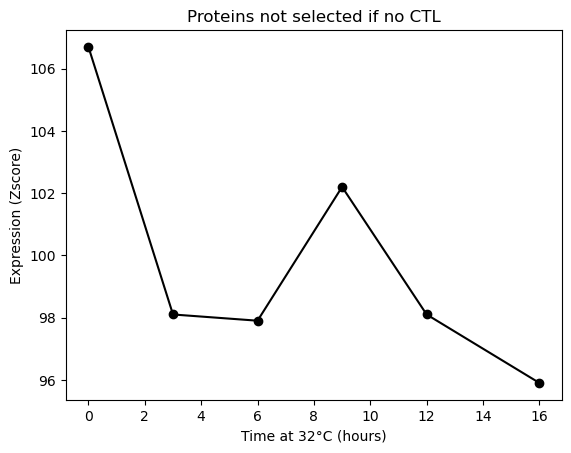

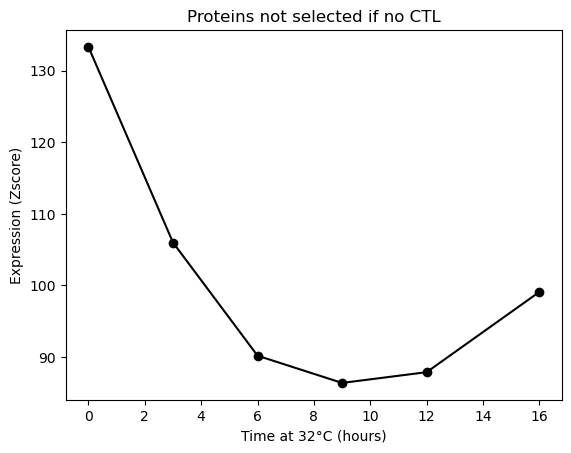

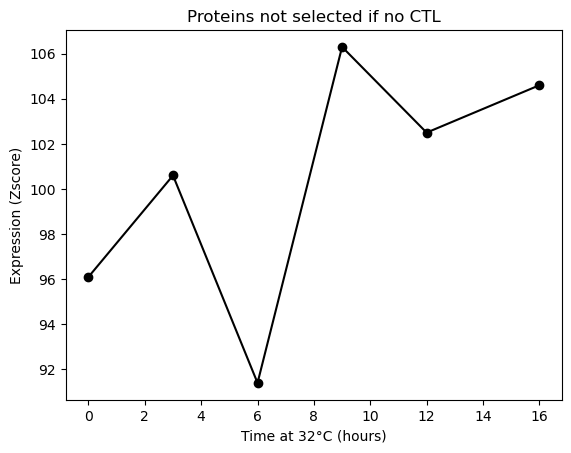

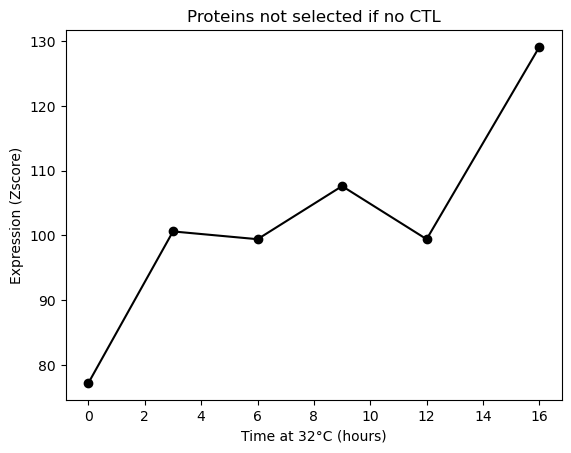

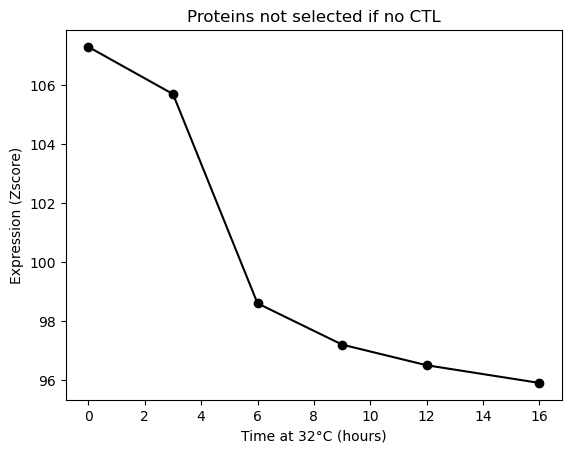

In [36]:
# With ctl but not in noCTL
for gene in df_lost_if_noCTL.head(5).index:
    data = df_lost_if_noCTL.loc[gene]
    data.index = [0, 3, 6, 9, 12, 16]
    plt.plot(data.T, marker= 'o', color='k')
    plt.title('Proteins not selected if no CTL')
    plt.ylabel('Expression (Zscore)')
    plt.xlabel('Time at 32°C (hours)')
    plt.show()

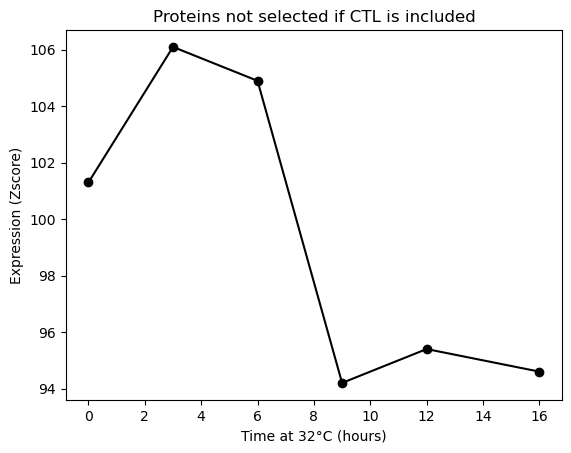

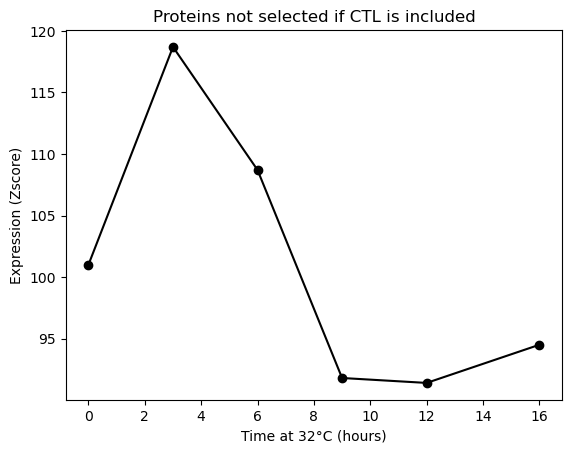

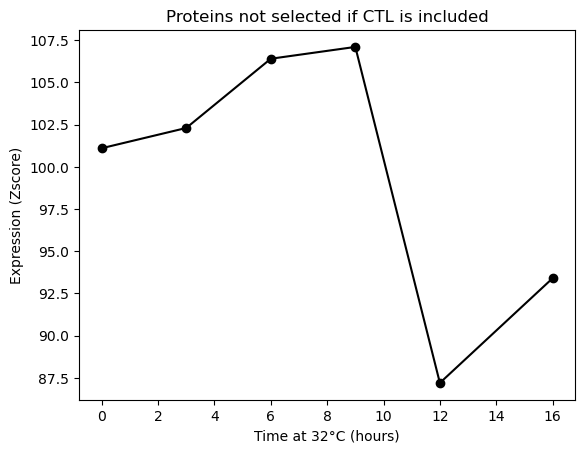

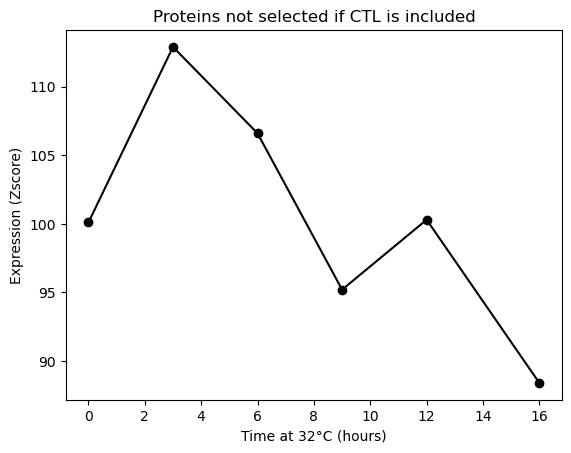

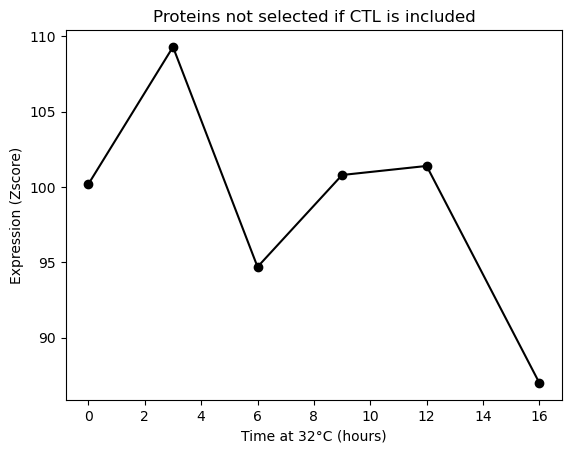

In [37]:
for gene in df_lost_if_withCTL.head(5).index:
    data = df_lost_if_withCTL.loc[gene]
    
    data.index = [0, 3, 6, 9, 12, 16]
    plt.plot(data.T, marker= 'o', color='k')
    plt.title('Proteins not selected if CTL is included')
    plt.ylabel('Expression (Zscore)')
    plt.xlabel('Time at 32°C (hours)')
    
    plt.show()

## Clusters

#### KMeans

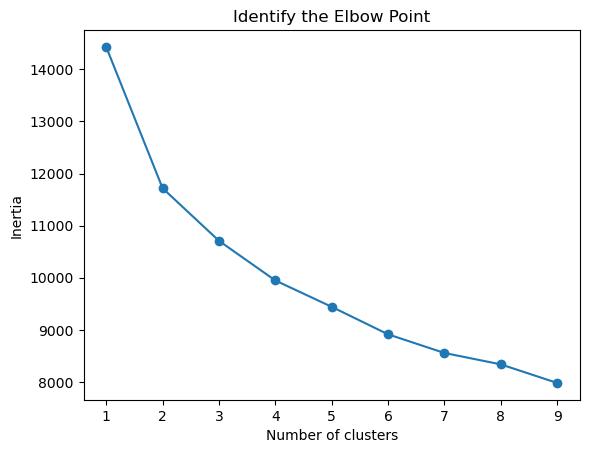

Best number is 2


In [38]:
# Calculate Similarity/Distance
from sklearn.cluster import KMeans

# Determine the optimal number of clusters using the elbow method
# "inertia" is the sum of squared distances of samples to their closest cluster center.
inertia = []
for n_clusters in range(1, 10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    kmeans.fit(df_zscore)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 10), inertia, marker='o')
plt.title('Identify the Elbow Point')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

print('Best number is 2')

#### Dendrogram

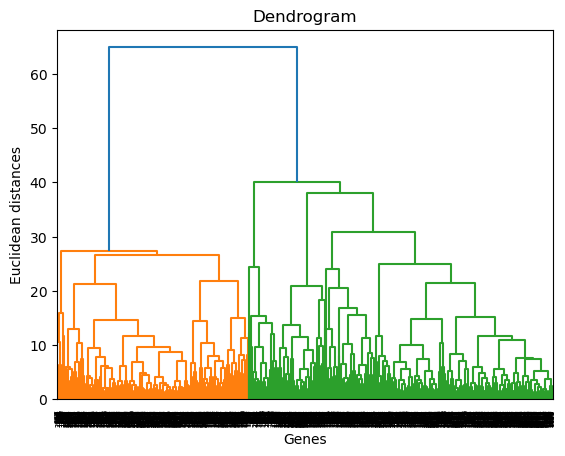

In [39]:
# Create the dendrogram to determine the optimal clusters
dendrogram = sch.dendrogram(sch.linkage(df_zscore, method='ward'))
plt.title('Dendrogram')
plt.xlabel('Genes')
plt.ylabel('Euclidean distances')
plt.show()

In [40]:
# Fit hierarchical clustering with the chosen number of clusters
optimal_clusters = 2
hierarchical = AgglomerativeClustering(n_clusters=optimal_clusters, metric='euclidean', linkage='ward')
df_zscore['Cluster'] = hierarchical.fit_predict(df_zscore)

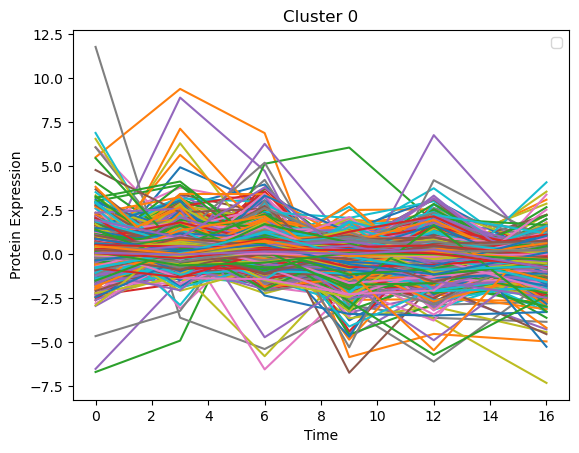

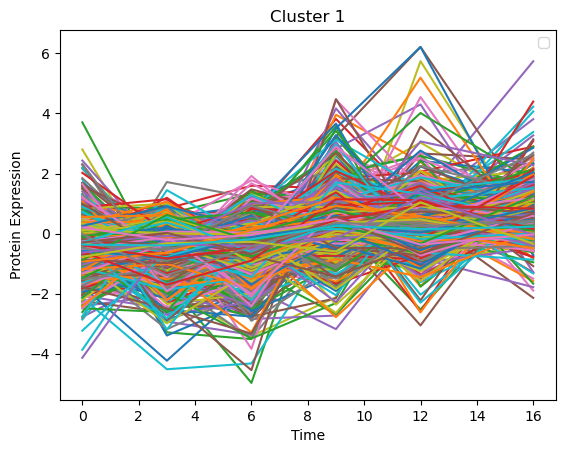

In [41]:
# Plot the time series of each cluster
cluster_col = df_zscore.pop('Cluster')
for cluster in range(optimal_clusters):
    cluster_data = df_zscore[cluster_col == cluster]
    cluster_data.columns = [0, 3, 6, 9, 12, 16]
    for gene in cluster_data.index:
        plt.plot(cluster_data.columns, cluster_data.loc[gene], label=f'Gene {gene}')
        
    plt.title(f'Cluster {cluster}')
    plt.xlabel('Time')
    plt.ylabel('Protein Expression')
    plt.legend('')
    plt.show()

## select proteins from coefficient of variation ?

### general Variation (all the conditions)

C:\Users\kja11\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


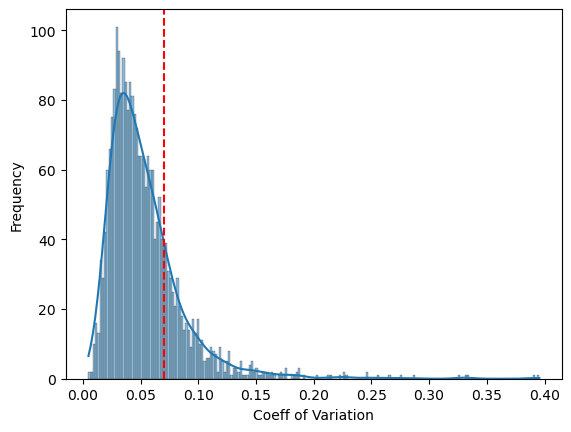

In [42]:
# coefficient of variation (CV) of gene expression across time points
cv_expression = df_median.std(axis=1) / df_median.mean(axis=1)

seaborn.histplot(cv_expression, bins=200, kde=True)
# plt.title('Histogram of the Coeff of Variation')
plt.xlabel('Coeff of Variation')
plt.ylabel('Frequency')

threshold = 0.07
plt.axvline(threshold,color="red",linestyle="--")
plt.show()

In [43]:
print(len(cv_expression[cv_expression > threshold]))

HighCV_prot = cv_expression[cv_expression > threshold].index
df_HighCV = df[df.index.isin(HighCV_prot)]

targets = 'CIRBP', 'RBM3', 'SMYD5'
df_HighCV.loc[targets,:]

503


,Ctrl_BR1,Ctrl_BR2,Ctrl_BR3,3h_BR1,3h_BR2,3h_BR3,6h_BR1,6h_BR2,6h_BR3,9h_BR1,9h_BR2,9h_BR3,12h_BR1,12h_BR2,12h_BR3,16h_BR1,16h_BR2,16h_BR3
Gene,,,,,,,,,,,,,,,,,,
CIRBP,79.2,101.4,88.4,78.7,92.5,96.6,86.9,84.4,94.5,96.3,95.7,113.2,126.1,113.9,98.2,114.9,121.1,117.9
RBM3,80.3,90.6,85.4,79.8,85.5,94.5,88.8,83.5,98.6,102.3,98.5,102.7,104.8,88.9,121.1,127.3,104.0,163.3
SMYD5,101.6,100.2,111.3,119.4,121.4,98.9,95.0,119.9,101.0,82.8,107.0,100.5,96.7,98.9,91.0,78.6,81.2,94.7


In [44]:
set1 = set(high_Rval_prot_noCTL)
set2 = set(HighCV_prot)

common_elements = set(set1).intersection(set2)
common_elements = list(common_elements)
print(len(common_elements), 'proteins are similar with the 302 of the rvalue < 0.6')

108 proteins are similar with the 302 of the rvalue < 0.6


### Variation between CTRL and 3h to select early response proteins

C:\Users\kja11\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


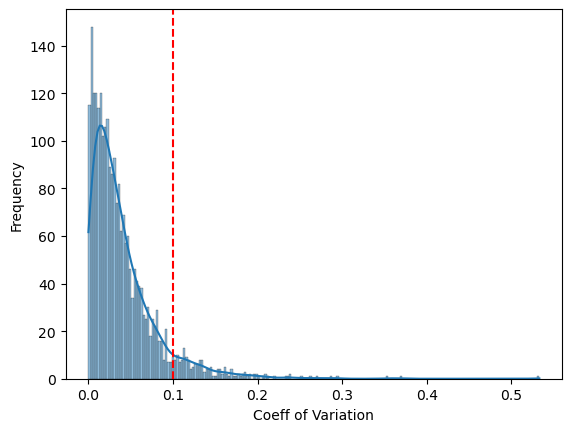

In [45]:
# coefficient of variation (CV) of gene expression across time points
cv_expression = df_median.iloc[:,:2].std(axis=1) / df_median.iloc[:,:2].mean(axis=1)

seaborn.histplot(cv_expression, bins=200, kde=True)
# plt.title('Histogram of the Coeff of Variation')
plt.xlabel('Coeff of Variation')
plt.ylabel('Frequency')

threshold = 0.1
plt.axvline(threshold,color="red",linestyle="--")
plt.show()

In [46]:
print(len(cv_expression[cv_expression > threshold]))

HighCV_prot = cv_expression[cv_expression > threshold].index
df_HighCV = df[df.index.isin(HighCV_prot)]

print('SMYD5 is here, not the two other. This is normal they changed at 9H')
targets = 'SMYD5'
df_HighCV.loc[targets].head()

179
SMYD5 is here, not the two other. This is normal they changed at 9H


Ctrl_BR1    101.6
Ctrl_BR2    100.2
Ctrl_BR3    111.3
3h_BR1      119.4
3h_BR2      121.4
Name: SMYD5, dtype: float64